In [2]:
# Parameters (overridden during execution)
EPOCHS = 20
RUN_ID = 1
OUT_DIR = "/kaggle/working/outputs"

In [3]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [4]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer, PatchEmbed
from torchinfo import summary
from torchview import draw_graph

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter

In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [8]:
# -------------------------
# Config (dynamic params)
# -------------------------
BATCH_SIZE = 6
IMG_SIZE   = 224

# -------------------------
# Load data
# -------------------------
# data = np.load("/kaggle/input/pneumoniamnist.npz")
''''''




''

In [9]:
train_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)


print(train_df.shape)
train_df.head()


(30227, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [10]:
df = (
    train_df
    .groupby("patientId")["Target"]
    .max()
    .reset_index()
    .rename(columns={"Target": "label"})
)

print("Raw rows:", len(train_df))
print("Unique images:", len(df))

Raw rows: 30227
Unique images: 26684


In [11]:
from sklearn.model_selection import train_test_split

# First split: Train vs Temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

# Second split: Val vs Test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (18678, 2)
Val: (4003, 2)
Test: (4003, 2)


In [12]:
import os
import pydicom
import numpy as np
import random

TRAIN_IMG_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import timm


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

In [13]:
def show_random_images_per_class(
    dataset,
    class_names,
    n_per_class=5,
    seed=42,
    image_names=None
):
    """
    Displays n random images per class in an m x n grid.
    If image_names is None, uses ClassName_index.
    """

    random.seed(seed)
    torch.manual_seed(seed)

    labels = dataset.labels.cpu().numpy()
    images = dataset.images.cpu()
    num_classes = len(class_names)

    class_indices = [
        np.where(labels == c)[0]
        for c in range(num_classes)
    ]

    fig, axes = plt.subplots(
        num_classes,
        n_per_class,
        figsize=(3 * n_per_class, 3 * num_classes),
        squeeze=False
    )

    for cls in range(num_classes):
        idxs = class_indices[cls]
        k = min(n_per_class, len(idxs))
        selected = np.random.choice(idxs, size=k, replace=False)

        for col, idx in enumerate(selected):
            img = images[idx].permute(1, 2, 0).numpy()
            img = img / 255.0  # correct float range for imshow

            ax = axes[cls, col]
            ax.imshow(img)
            ax.axis("off")

            # Image title
            if image_names is not None:
                title = image_names[idx]
            else:
                title = f"{class_names[cls]}_{idx}"

            ax.set_title(title, fontsize=9)

            if col == 0:
                ax.set_ylabel(
                    class_names[cls],
                    rotation=90,
                    fontsize=12,
                    labelpad=10
                )

    plt.tight_layout()
    plt.show()

class_names = ["Normal", "Pneumonia"]

show_random_images_per_class(
    train_dataset,
    class_names=class_names,
    n_per_class=5
)

NameError: name 'train_dataset' is not defined

In [14]:
import os
import torch
import pydicom
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [15]:
class RSNAPneumoniaDataset(Dataset):
    def __init__(self, df, image_dir, img_size):
        """
        df: DataFrame with columns ['patientId', 'label']
        image_dir: directory containing .dcm files
        img_size: target image size (e.g., 224)
        """
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def load_dicom(self, path):
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)

        # Normalize per image (important for RSNA)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        return img

    def __getitem__(self, idx):
        patient_id = self.df.loc[idx, "patientId"]
        label = self.df.loc[idx, "label"]

        dcm_path = os.path.join(self.image_dir, f"{patient_id}.dcm")

        # Load image
        img = self.load_dicom(dcm_path)

        # (H, W) → (1, H, W)
        img = torch.from_numpy(img).unsqueeze(0)

        # Grayscale → RGB
        img = img.repeat(3, 1, 1)   # (3, H, W)

        # Resize
        img = F.interpolate(
            img.unsqueeze(0),
            size=(self.img_size, self.img_size),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        return img, torch.tensor(label, dtype=torch.long)


In [16]:
IMAGE_DIR = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images"
IMG_SIZE = 224
BATCH_SIZE = 6


In [17]:
import cv2

In [18]:
class TwoMaxMinusMinPool2d(nn.Module):
    """
    Pooling layer that computes:
        output = (2 * max_pool) - min_pool

    Uses only optimized max-pooling kernels.
    Computational cost ~ 2× max pooling.
    Output shape matches standard pooling.
    """

    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()

        # Match PyTorch pooling semantics
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding

    def forward(self, x):
        # Fast max pooling (optimized C++/CUDA)
        max_pool = F.max_pool2d(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Fast min pooling via negation trick
        min_pool = -F.max_pool2d(
            -x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        # Final contrast-enhanced response
        return (2.0 * max_pool) - min_pool

In [19]:
train_dataset = RSNAPneumoniaDataset(train_df, IMAGE_DIR, IMG_SIZE)
val_dataset   = RSNAPneumoniaDataset(val_df,   IMAGE_DIR, IMG_SIZE)
test_dataset  = RSNAPneumoniaDataset(test_df,  IMAGE_DIR, IMG_SIZE)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


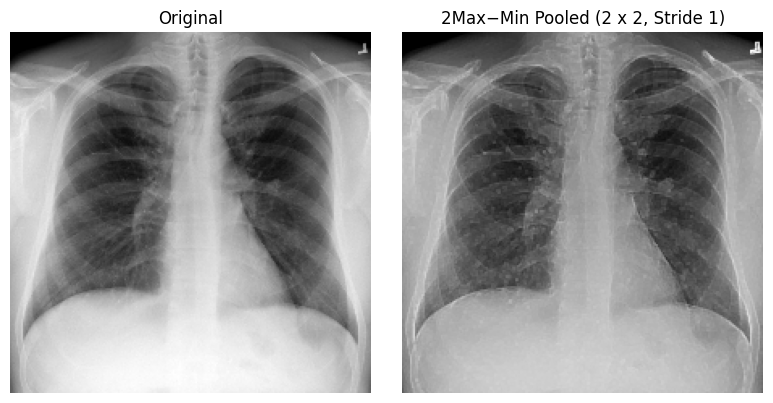

In [20]:
KERNEL_SIZE = 2
STRIDE = 1

# Get one batch
images, labels = next(iter(train_loader))

# Take first image only
img = images[0:1]  # shape: (1, C, H, W)

pool = TwoMaxMinusMinPool2d(kernel_size=KERNEL_SIZE, stride=STRIDE)
pool.eval()

with torch.no_grad():
    pooled = pool(img)

# Convert to numpy for display
img_np = img[0].cpu().numpy()
pooled_np = pooled[0].cpu().numpy()

# Pick one channel to visualize
ch = 0

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(img_np[ch], cmap="gray")
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(pooled_np[ch], cmap="gray")
axs[1].set_title(F"2Max−Min Pooled ({KERNEL_SIZE} x {KERNEL_SIZE}, Stride {STRIDE})")
axs[1].axis("off")

plt.tight_layout()
plt.show()

In [21]:
class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load pretrained MobileNetV2
        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks1 = len(pretrained_model.features)

        # Freeze first half of MobileNetV2 efficiently
        for param in pretrained_model.features[:num_blocks1 // 2].parameters():
            param.requires_grad = False

        # Split MobileNetV2 into blocks
        self.mobilenet_feature_blocks_1 = nn.Sequential(*pretrained_model.features[:num_blocks1 - 3])
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks1 - 3]
        self.mobilenet_block_mid = pretrained_model.features[num_blocks1 - 2]
        self.mobilenet_block_last = pretrained_model.features[num_blocks1 - 1]

        # Output channel sizes
        ch_2nd_last = self.mobilenet_block_2nd_last.out_channels # 160
        ch_last = self.mobilenet_block_last.out_channels # 1280
        ch_mid = self.mobilenet_block_mid.out_channels # 320
        ch_concat = ch_last + ch_2nd_last # 1440
        
        # CNN to ViT adapter
        adapter_layers = [
            nn.Conv2d(ch_mid, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.GELU(),
            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        ]

        self.cnn_to_vit_adapter = nn.Sequential(*adapter_layers)

        # Initialize ViT encoder for 56×56 feature maps
        # Vit - 2 - stride variation 
        self.vit_encoder1 = VisionTransformer(
            img_size=56,
            patch_size=8,
            in_chans=16,
            num_classes=0,
            embed_dim=64,
            depth=2,
            num_heads=4,
            mlp_ratio=2,
            qkv_bias=True,
            norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()  # return features, not logits
        
        
        # Enable overlapping patches by changing patch projection stride
        old_proj = self.vit_encoder1.patch_embed.proj
        self.vit_encoder1.patch_embed.proj = nn.Conv2d(
            old_proj.in_channels,
            old_proj.out_channels,
            kernel_size=8,
            stride=4,
            bias=old_proj.bias is not None,
        )
        
        
        # Infer number of patches produced by the new stride
        img_h, img_w = self.vit_encoder1.patch_embed.img_size
        dummy = torch.zeros(1, old_proj.in_channels, img_h, img_w)
        
        with torch.no_grad():
            _, _, h, w = self.vit_encoder1.patch_embed.proj(dummy).shape
        
        num_patches = h * w
        self.vit_encoder1.patch_embed.num_patches = num_patches
        
        
        # Reset positional embeddings to match new token count
        self.vit_encoder1.pos_embed = nn.Parameter(
            torch.zeros(1, num_patches + 1, self.vit_encoder1.embed_dim)
        )
        nn.init.trunc_normal_(self.vit_encoder1.pos_embed, std=0.02)

        self.twomax_minus_min_pool = TwoMaxMinusMinPool2d(
            kernel_size=2,
            stride=1
        )

        # Vit - 1 - No stride variation 
        self.vit_encoder2 = VisionTransformer(
            img_size=28, patch_size=7, in_chans=32,
            num_classes=0, embed_dim=64,
            depth=2, num_heads=4, mlp_ratio=2,
            qkv_bias=True, norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()

        # CNN parallel head (from features_last only)
        self.cnn_parallel_head = nn.Sequential(
            nn.Conv2d(ch_concat, 96, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3, padding=0), nn.BatchNorm2d(96), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )
        '''
        # 6) Parallel on 4th-last features
        self.parallel2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=ch_mid,
                out_channels=ch_mid,
                kernel_size=3, stride=1, padding=0
            ),
            MaxAvgPool2d(pool_size=(3,3), stride=(1,1)),
            nn.Conv2d(ch_mid * 2, 64, 3, padding=0), nn.BatchNorm2d(64), nn.GELU(),
            nn.Conv2d(64, 8, 3, padding=0), nn.BatchNorm2d(8), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )
        '''
        # Final classifier
        self.classifier_head = nn.Linear(64 + 64 + 96, num_classes)

    def forward(self, x):
        features_1 = self.mobilenet_feature_blocks_1(x)
        features_2nd_last = self.mobilenet_block_2nd_last(features_1)
        features_mid = self.mobilenet_block_mid(features_2nd_last)
        features_last = self.mobilenet_block_last(features_mid)

        # Always resize to match before concat
        concatenated_cnn_features = torch.cat([features_last, features_2nd_last], dim=1)

        x = features_mid
        intermediate = None
        
        for i, layer in enumerate(self.cnn_to_vit_adapter):
            x = layer(x)
        
            # capture second-last stage (before last 4 layers)
            if i == len(self.cnn_to_vit_adapter) - 5:
                intermediate = x
        
        vit_input1 = x                 # full adapter output
        vit_input2 = intermediate      # derived from vit_input1 path
        
        vit_features1 = self.vit_encoder1(vit_input1) # 64

        # Apply (2*max - min) pooling
        vit_input2 = self.twomax_minus_min_pool(vit_input2)

        # Resize to 28x28 explicitly
        vit_input2 = F.interpolate(
            vit_input2,
            size=(28, 28),
            mode="bilinear",
            align_corners=False
        )

        vit_features2 = self.vit_encoder2(vit_input2) # 32
                
        # CNN parallel branch from final MobileNet block
        cnn_features = self.cnn_parallel_head(concatenated_cnn_features) # 96
        # cnn_features_2 = self.parallel2(features_mid)   # [B, 64]

        # Concatenate and classify
        combined = torch.cat([vit_features1, vit_features2, cnn_features], dim=1)
        return self.classifier_head(combined)

In [22]:
model = CNN_ViT_Model(num_classes=2)
summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 182MB/s]


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 2]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

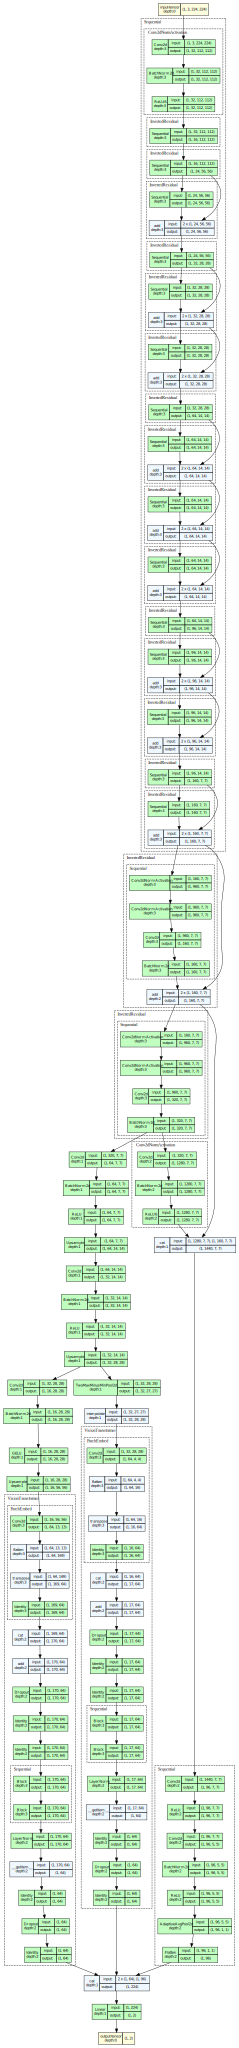

In [23]:
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [24]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()

        # Skip AUC if only one class is present
        if np.unique(class_y_true).size < 2:
            continue
        try:
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        except ValueError:
            continue

    auc_avg = np.mean(auc_scores) if auc_scores else 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [25]:
# Hyperparameters
num_epochs       = EPOCHS
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [26]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric: [] for metric in metric_names}
val_metrics_history = {metric: [] for metric in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0.0
    all_train_predictions = []
    all_train_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_predictions.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_train_loss = total_train_loss / len(train_loader)
    all_train_predictions = np.array(all_train_predictions)
    all_train_targets = np.array(all_train_targets)

    train_metrics = custom_metrics(torch.tensor(all_train_predictions), torch.tensor(all_train_targets), average_train_loss)
    training_metrics_line = "Train Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(training_metrics_line)

    for metric in metric_names:
        train_metrics_history[metric].append(train_metrics[metric])

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    all_val_predictions = []
    all_val_targets = []
    start_val_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            all_val_predictions.extend(outputs.detach().cpu().numpy())
            all_val_targets.extend(targets.detach().cpu().numpy())

    end_val_time = time.time()
    epoch_validation_time = end_val_time - start_val_time
    total_validation_time += epoch_validation_time

    average_val_loss = total_val_loss / len(val_loader)
    all_val_predictions = np.array(all_val_predictions)
    all_val_targets = np.array(all_val_targets)

    val_metrics = custom_metrics(torch.tensor(all_val_predictions), torch.tensor(all_val_targets), average_val_loss)
    validation_metrics_line = "Val Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(validation_metrics_line)

    for metric in metric_names:
        val_metrics_history[metric].append(val_metrics[metric])

    # Update LR via scheduler rather than manual mutliplication
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f} — LR: {current_lr:.6f}")

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / (epoch + 1)
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Epoch [1/20]: 100%|██████████| 3113/3113 [03:51<00:00, 13.44it/s]


Train Metrics - loss: 0.4104, accuracy: 0.8089, precision: 0.7913, recall: 0.8089, f1_score: 0.7936, specificity: 0.9265, sensitivity: 0.4045, mcc: 0.3892, auc: 0.8194


Validating Model: 100%|██████████| 668/668 [00:48<00:00, 13.85it/s]


Val Metrics - loss: 0.3713, accuracy: 0.8291, precision: 0.8253, recall: 0.8291, f1_score: 0.8270, specificity: 0.8994, sensitivity: 0.5876, mcc: 0.4992, auc: 0.8647
Epoch 0/20 — Loss: 0.2131 — LR: 0.000100


Training Epoch [2/20]: 100%|██████████| 3113/3113 [02:52<00:00, 18.05it/s]


Train Metrics - loss: 0.3719, accuracy: 0.8354, precision: 0.8244, recall: 0.8354, f1_score: 0.8256, specificity: 0.9332, sensitivity: 0.4990, mcc: 0.4874, auc: 0.8455


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.12it/s]


Val Metrics - loss: 0.3644, accuracy: 0.8384, precision: 0.8321, recall: 0.8384, f1_score: 0.8343, specificity: 0.9142, sensitivity: 0.5776, mcc: 0.5170, auc: 0.8673
Epoch 1/20 — Loss: 0.2480 — LR: 0.000100


Training Epoch [3/20]: 100%|██████████| 3113/3113 [02:51<00:00, 18.11it/s]


Train Metrics - loss: 0.3235, accuracy: 0.8579, precision: 0.8516, recall: 0.8579, f1_score: 0.8531, specificity: 0.9328, sensitivity: 0.6003, mcc: 0.5709, auc: 0.8968


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.73it/s]


Val Metrics - loss: 0.3754, accuracy: 0.8259, precision: 0.8161, recall: 0.8259, f1_score: 0.8190, specificity: 0.9155, sensitivity: 0.5177, mcc: 0.4690, auc: 0.8578
Epoch 2/20 — Loss: 0.5913 — LR: 0.000100


Training Epoch [4/20]: 100%|██████████| 3113/3113 [02:48<00:00, 18.46it/s]


Train Metrics - loss: 0.2768, accuracy: 0.8823, precision: 0.8789, recall: 0.8823, f1_score: 0.8800, specificity: 0.9390, sensitivity: 0.6873, mcc: 0.6516, auc: 0.9223


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.84it/s]


Val Metrics - loss: 0.4275, accuracy: 0.8186, precision: 0.8178, recall: 0.8186, f1_score: 0.8182, specificity: 0.8849, sensitivity: 0.5909, mcc: 0.4781, auc: 0.8536
Epoch 3/20 — Loss: 0.6886 — LR: 0.000100


Training Epoch [5/20]: 100%|██████████| 3113/3113 [02:49<00:00, 18.36it/s]


Train Metrics - loss: 0.2118, accuracy: 0.9120, precision: 0.9110, recall: 0.9120, f1_score: 0.9114, specificity: 0.9484, sensitivity: 0.7866, mcc: 0.7448, auc: 0.9565


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.50it/s]


Val Metrics - loss: 0.4778, accuracy: 0.8021, precision: 0.8055, recall: 0.8021, f1_score: 0.8037, specificity: 0.8655, sensitivity: 0.5843, mcc: 0.4427, auc: 0.8219
Epoch 4/20 — Loss: 1.4773 — LR: 0.000100


Training Epoch [6/20]: 100%|██████████| 3113/3113 [02:51<00:00, 18.13it/s]


Train Metrics - loss: 0.1647, accuracy: 0.9340, precision: 0.9337, recall: 0.9340, f1_score: 0.9338, specificity: 0.9594, sensitivity: 0.8465, mcc: 0.8100, auc: 0.9742


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.40it/s]


Val Metrics - loss: 0.5374, accuracy: 0.7989, precision: 0.8100, recall: 0.7989, f1_score: 0.8035, specificity: 0.8491, sensitivity: 0.6264, mcc: 0.4540, auc: 0.8178
Epoch 5/20 — Loss: 1.1100 — LR: 0.000100


Training Epoch [7/20]: 100%|██████████| 3113/3113 [02:51<00:00, 18.13it/s]


Train Metrics - loss: 0.1346, accuracy: 0.9488, precision: 0.9485, recall: 0.9488, f1_score: 0.9486, specificity: 0.9694, sensitivity: 0.8779, mcc: 0.8524, auc: 0.9826


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.87it/s]


Val Metrics - loss: 0.5742, accuracy: 0.8029, precision: 0.8027, recall: 0.8029, f1_score: 0.8028, specificity: 0.8733, sensitivity: 0.5610, mcc: 0.4348, auc: 0.8273
Epoch 6/20 — Loss: 0.4099 — LR: 0.000100


Training Epoch [8/20]: 100%|██████████| 3113/3113 [02:52<00:00, 18.06it/s]


Train Metrics - loss: 0.1140, accuracy: 0.9577, precision: 0.9576, recall: 0.9577, f1_score: 0.9577, specificity: 0.9737, sensitivity: 0.9028, mcc: 0.8786, auc: 0.9873


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 19.01it/s]


Val Metrics - loss: 0.6715, accuracy: 0.8154, precision: 0.8023, recall: 0.8154, f1_score: 0.8056, specificity: 0.9168, sensitivity: 0.4667, mcc: 0.4270, auc: 0.8187
Epoch 7/20 — Loss: 0.3997 — LR: 0.000100


Training Epoch [9/20]: 100%|██████████| 3113/3113 [02:50<00:00, 18.23it/s]


Train Metrics - loss: 0.0969, accuracy: 0.9638, precision: 0.9637, recall: 0.9638, f1_score: 0.9638, specificity: 0.9775, sensitivity: 0.9166, mcc: 0.8961, auc: 0.9911


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.96it/s]


Val Metrics - loss: 0.5929, accuracy: 0.8084, precision: 0.8076, recall: 0.8084, f1_score: 0.8080, specificity: 0.8781, sensitivity: 0.5687, mcc: 0.4488, auc: 0.8272
Epoch 8/20 — Loss: 0.2357 — LR: 0.000100


Training Epoch [10/20]: 100%|██████████| 3113/3113 [02:51<00:00, 18.20it/s]


Train Metrics - loss: 0.0842, accuracy: 0.9693, precision: 0.9693, recall: 0.9693, f1_score: 0.9693, specificity: 0.9806, sensitivity: 0.9306, mcc: 0.9120, auc: 0.9927


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.67it/s]


Val Metrics - loss: 0.6792, accuracy: 0.8099, precision: 0.7988, recall: 0.8099, f1_score: 0.8026, specificity: 0.9045, sensitivity: 0.4845, mcc: 0.4202, auc: 0.8129
Epoch 9/20 — Loss: 0.0109 — LR: 0.000100


Training Epoch [11/20]: 100%|██████████| 3113/3113 [02:52<00:00, 18.07it/s]


Train Metrics - loss: 0.0827, accuracy: 0.9709, precision: 0.9709, recall: 0.9709, f1_score: 0.9709, specificity: 0.9813, sensitivity: 0.9351, mcc: 0.9165, auc: 0.9926


Validating Model: 100%|██████████| 668/668 [00:33<00:00, 19.76it/s]


Val Metrics - loss: 0.6510, accuracy: 0.8129, precision: 0.8127, recall: 0.8129, f1_score: 0.8128, specificity: 0.8797, sensitivity: 0.5831, mcc: 0.4634, auc: 0.8249
Epoch 10/20 — Loss: 0.8140 — LR: 0.000097


Training Epoch [13/20]: 100%|██████████| 3113/3113 [02:52<00:00, 18.08it/s]


Train Metrics - loss: 0.0620, accuracy: 0.9791, precision: 0.9790, recall: 0.9791, f1_score: 0.9790, specificity: 0.9880, sensitivity: 0.9482, mcc: 0.9398, auc: 0.9955


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.86it/s]


Val Metrics - loss: 0.8759, accuracy: 0.8179, precision: 0.8030, recall: 0.8179, f1_score: 0.8049, specificity: 0.9281, sensitivity: 0.4390, mcc: 0.4242, auc: 0.8128
Epoch 12/20 — Loss: 0.0023 — LR: 0.000091


Training Epoch [14/20]: 100%|██████████| 3113/3113 [02:52<00:00, 18.03it/s]


Train Metrics - loss: 0.0469, accuracy: 0.9835, precision: 0.9835, recall: 0.9835, f1_score: 0.9835, specificity: 0.9900, sensitivity: 0.9613, mcc: 0.9527, auc: 0.9975


Validating Model: 100%|██████████| 668/668 [00:36<00:00, 18.52it/s]


Val Metrics - loss: 0.7852, accuracy: 0.8201, precision: 0.8089, recall: 0.8201, f1_score: 0.8120, specificity: 0.9152, sensitivity: 0.4933, mcc: 0.4473, auc: 0.8331
Epoch 13/20 — Loss: 0.0074 — LR: 0.000089


Training Epoch [15/20]: 100%|██████████| 3113/3113 [02:51<00:00, 18.18it/s]


Train Metrics - loss: 0.0503, accuracy: 0.9820, precision: 0.9820, recall: 0.9820, f1_score: 0.9820, specificity: 0.9899, sensitivity: 0.9548, mcc: 0.9483, auc: 0.9971


Validating Model: 100%|██████████| 668/668 [00:34<00:00, 19.28it/s]


Val Metrics - loss: 0.7969, accuracy: 0.8116, precision: 0.8058, recall: 0.8116, f1_score: 0.8083, specificity: 0.8920, sensitivity: 0.5355, mcc: 0.4429, auc: 0.8157
Epoch 14/20 — Loss: 0.0314 — LR: 0.000086


Training Epoch [16/20]: 100%|██████████| 3113/3113 [02:57<00:00, 17.54it/s]


Train Metrics - loss: 0.0463, accuracy: 0.9847, precision: 0.9847, recall: 0.9847, f1_score: 0.9847, specificity: 0.9914, sensitivity: 0.9620, mcc: 0.9562, auc: 0.9970


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.61it/s]


Val Metrics - loss: 0.8083, accuracy: 0.8191, precision: 0.8039, recall: 0.8191, f1_score: 0.8050, specificity: 0.9323, sensitivity: 0.4302, mcc: 0.4248, auc: 0.8220
Epoch 15/20 — Loss: 0.0012 — LR: 0.000083


Training Epoch [17/20]: 100%|██████████| 3113/3113 [02:52<00:00, 18.06it/s]


Train Metrics - loss: 0.0364, accuracy: 0.9884, precision: 0.9884, recall: 0.9884, f1_score: 0.9884, specificity: 0.9927, sensitivity: 0.9736, mcc: 0.9667, auc: 0.9982


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.85it/s]


Val Metrics - loss: 0.7905, accuracy: 0.8204, precision: 0.8129, recall: 0.8204, f1_score: 0.8157, specificity: 0.9033, sensitivity: 0.5355, mcc: 0.4621, auc: 0.8168
Epoch 16/20 — Loss: 0.0121 — LR: 0.000081


Training Epoch [18/20]: 100%|██████████| 3113/3113 [02:52<00:00, 18.09it/s]


Train Metrics - loss: 0.0348, accuracy: 0.9888, precision: 0.9888, recall: 0.9888, f1_score: 0.9888, specificity: 0.9931, sensitivity: 0.9741, mcc: 0.9679, auc: 0.9984


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.59it/s]


Val Metrics - loss: 0.8898, accuracy: 0.8134, precision: 0.8057, recall: 0.8134, f1_score: 0.8087, specificity: 0.8981, sensitivity: 0.5222, mcc: 0.4418, auc: 0.8251
Epoch 17/20 — Loss: 0.1240 — LR: 0.000078


Training Epoch [19/20]: 100%|██████████| 3113/3113 [02:55<00:00, 17.76it/s]


Train Metrics - loss: 0.0325, accuracy: 0.9897, precision: 0.9897, recall: 0.9897, f1_score: 0.9897, specificity: 0.9940, sensitivity: 0.9750, mcc: 0.9705, auc: 0.9984


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 18.74it/s]


Val Metrics - loss: 0.7935, accuracy: 0.8201, precision: 0.8091, recall: 0.8201, f1_score: 0.8123, specificity: 0.9142, sensitivity: 0.4967, mcc: 0.4484, auc: 0.8212
Epoch 18/20 — Loss: 0.1744 — LR: 0.000076


Training Epoch [20/20]: 100%|██████████| 3113/3113 [02:53<00:00, 17.93it/s]


Train Metrics - loss: 0.0259, accuracy: 0.9901, precision: 0.9901, recall: 0.9901, f1_score: 0.9901, specificity: 0.9938, sensitivity: 0.9774, mcc: 0.9716, auc: 0.9993


Validating Model: 100%|██████████| 668/668 [00:35<00:00, 19.06it/s]

Val Metrics - loss: 1.0590, accuracy: 0.8186, precision: 0.8060, recall: 0.8186, f1_score: 0.8090, specificity: 0.9187, sensitivity: 0.4745, mcc: 0.4375, auc: 0.8088
Epoch 19/20 — Loss: 0.2380 — LR: 0.000074
Total Training Time: 0:58:20.372905
Total Validation Time: 0:11:53.023045
Average Training Time per Epoch: 0:02:55.018645
Average Validation Time per Epoch: 0:00:35.651152


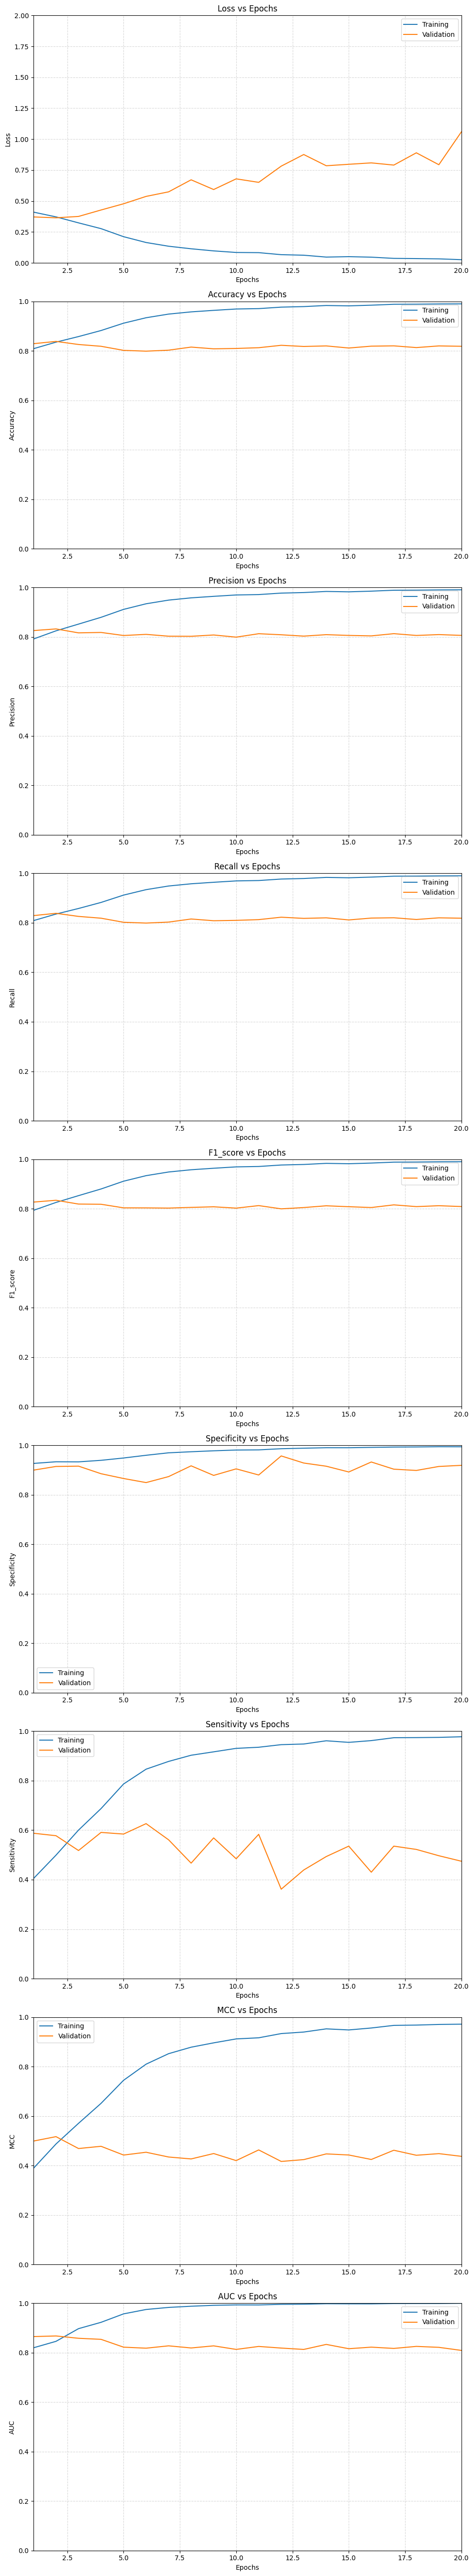

In [27]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(f"{metric_name.upper()} vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(f"{metric_name.capitalize()} vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        # Adjust xlim to avoid identical low and high limits.
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [28]:
# Testing loop
model.eval()
total_test_loss = 0.0
all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_test_loss += loss.item()

        all_test_predictions.extend(outputs.detach().cpu().numpy())
        all_test_targets.extend(targets.detach().cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)

average_test_loss = total_test_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_test_predictions), torch.tensor(all_test_targets), average_test_loss)
testing_metrics_line = "Test Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
print(testing_metrics_line)

Testing Model: 100%|██████████| 668/668 [00:45<00:00, 14.73it/s]

Test Metrics - loss: 0.9990, accuracy: 0.8286, precision: 0.8180, recall: 0.8286, f1_score: 0.8205, specificity: 0.9220, sensitivity: 0.5078, mcc: 0.4726, auc: 0.8162


In [29]:
# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_test_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_test_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# # Option 2: if using ImageFolder
# classes = dataset.classes

# Class names in correct index order
class_name_map = {
    0: "Normal",
    1: "Pneumonia Present",
}
classes = [class_name_map[i] for i in sorted(class_name_map.keys())]

# Get class names from the dataset
# classes = train_dataset.classes

# classes = label_encoder.classes_

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                   precision    recall  f1-score   support

           Normal     0.8656    0.9220    0.8929      3101
Pneumonia Present     0.6543    0.5078    0.5718       902

         accuracy                         0.8286      4003
        macro avg     0.7599    0.7149    0.7323      4003
     weighted avg     0.8180    0.8286    0.8205      4003

There were 686 errors in 4003 tests for an accuracy of  82.86
